# ETF Price prediction for 2017 onwards

- Author: Hathan Khatkar
- Dataset: https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/code Huge Stock Market Dataset -Boris Marjanovic
- Using a LSTM model we will predict the price of a particular ETF from 2017 onwards. As this is a time series problem LSTM is likely the best fit for the model, due to previous historical data can influence future and its long term memory across cells, whilst mitigating the vanishing gradient problem.
- We will use hyper parameter tuning using random search to optimize our model's predictions.
- We will use k-fold cross validation to monitor performance against unseen data, at regular epochs and also to identify overfitting throughout the learning process.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from scikeras.wrappers import KerasRegressor
from google.colab import drive
import matplotlib.pyplot as plt
import os


# Mount Google Drive
drive.mount('/content/drive')

#CSV file
file_path = '/content/drive/My Drive/Colab Notebooks/Predicting Stock Prices with LSTM Networks/aadr.us.csv'

# Load the data
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Preprocessing
# Using 'Close' prices for prediction
close_prices = data['Close'].values.reshape(-1, 1)

# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

#function to prepare the dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Define time steps (look back period)
time_step = 60

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# Create datasets for training and testing
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train (features): ", X_train.shape)
print("y_train (values): ", y_train.shape)

X_train (features):  (1191, 60, 1)
y_train (values):  (1191,)


In [ ]:
#LSTM model function creates model based on random search

def create_model(optimizer='adam', dropout_rate=0.0, lstm_units=50):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model



In [ ]:
# Wrap the Keras model for use in scikit-learn
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameter grid for tuning
param_dist = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout_rate': [0, 0.2, 0.4],
    'model__lstm_units': [50, 100],
    'batch_size': [10, 20],
    'epochs': [3, 5, 10, 20]
}

# Random Search will take 20 random sample combinations from the param_dist (with 3-fold cross validation)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search_result = random_search.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instea

In [ ]:
# Get the best model and its parameters (one that has the smallest mean squared error across the validation data)
print(f"Best: {random_search_result.best_score_} using {random_search_result.best_params_}")
best_model = random_search_result.best_estimator_

Best: 0.8047951853636336 using {'model__optimizer': 'adam', 'model__lstm_units': 100, 'model__dropout_rate': 0.2, 'epochs': 20, 'batch_size': 10}


In [ ]:
# Predictions against the training and test sets, if the test performs significantly worse to training this could indicate overfitting
train_predict = best_model.predict(X_train)
test_predict = best_model.predict(X_test)

train_predict = train_predict.reshape(-1, 1)
test_predict = test_predict.reshape(-1, 1)

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))

print(f'Train RMSE: {train_score}')
print(f'Test RMSE: {test_score}')

Train RMSE: 0.5759126702813616
Test RMSE: 0.9498992079153067


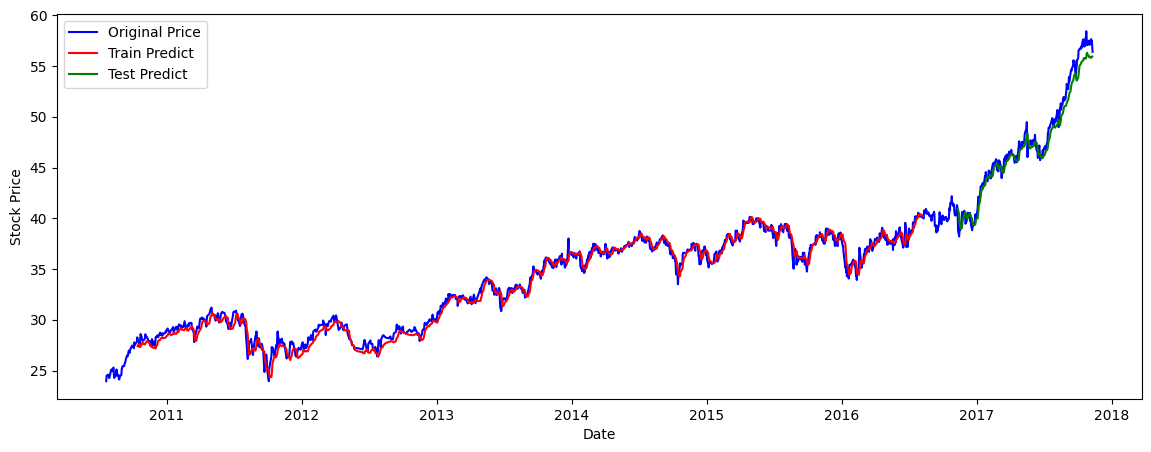

In [ ]:
# Visualize the results
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))
plt.plot(data.index, scaler.inverse_transform(scaled_data), color='blue', label='Original Price')
plt.plot(data.index[time_step:len(train_predict)+time_step], train_predict, color='red', label='Train Predict')
plt.plot(data.index[len(train_predict)+(time_step*2)+1:len(scaled_data)-1], test_predict, color='green', label='Test Predict')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 626.2078 - val_loss: 281.8749
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 123.4240 - val_loss: 109.6975
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 42.2297 - val_loss: 49.6338
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 23.5544 - val_loss: 30.9915
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 19.6874 - val_loss: 25.9371
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 19.2569 - val_loss: 24.5997
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 19.6027 - val_loss: 24.5751
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 19.2943 - val_loss: 22.9137
Epoch 9/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.9848 - val_loss: 23.5763


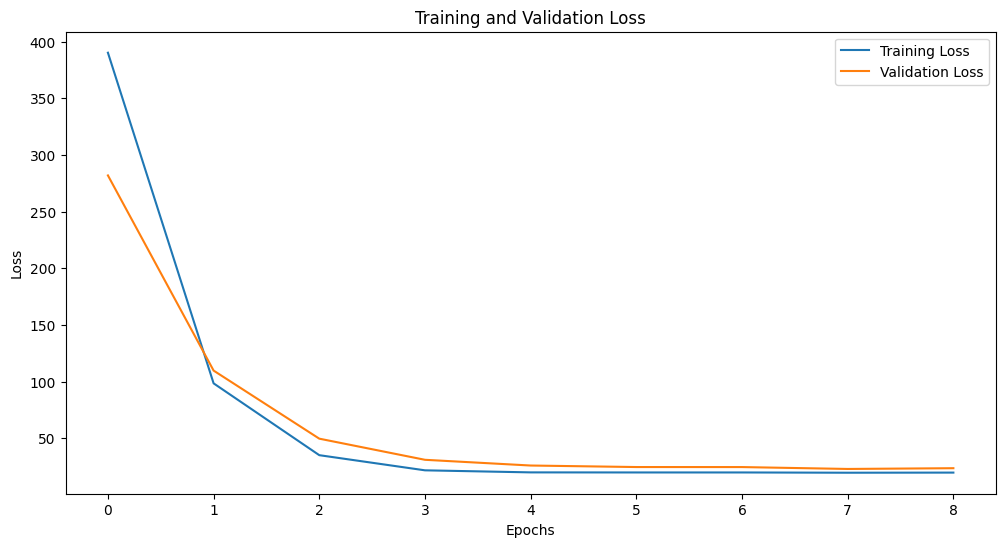

In [ ]:
#We can now look at the validation error history against the training to see if we can further minimize the number of epochs..
#... with early stopping (at a point where no significant learning occurs)
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

y_train = np.reshape(y_train, (-1, 1))

#these are taken from the best model's parameters above manually
best_params = {
    'optimizer': 'adam',
    'dropout_rate': 0.2,
    'lstm_units': 100,
    'epochs': 20,
    'batch_size': 10
}

model = create_model(
    optimizer=best_params['optimizer'],
    dropout_rate=best_params['dropout_rate'],
    lstm_units=best_params['lstm_units']
)

#refit model using same parameters, introduces early stopping if validation loss starts to level
history = model.fit(
    X_train, y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)]
)


# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
#Summary of our final model
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                       │ (None, 60, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 363,905 (1.39 MB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 242,604 (947.68 KB)